In [2]:
from pyface.qt import QtGui, QtCore

# NOTE hangs on "Run All"
%matplotlib notebook
%matplotlib
%gui qt

Using matplotlib backend: nbAgg


In [3]:
import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import sample

In [4]:
import matplotlib
#matplotlib.rcParams
import os 
#os.environ['ETS_TOOLKIT'] = 'qt4'
#os.environ['QT_API'] = 'pyqt'
import sys
print(sys.version)
#import surfer
#from surfer import Brain
#brain=Brain('fsaverage','both','inflated')

2.7.11 |Anaconda 2.0.1 (64-bit)| (default, Dec  6 2015, 18:08:32) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]


In [5]:
data_path = sample.data_path()
raw_fname = data_path + '/MEG/sample/sample_audvis_filt-0-40_raw.fif'

raw = mne.io.read_raw_fif(raw_fname, add_eeg_ref=False)
raw.set_eeg_reference()  # set EEG average reference
events = mne.find_events(raw, stim_channel='STI 014')

event_id = dict(aud_r=1)  # event trigger and conditions
tmin = -0.2  # start of each epoch (200ms before the trigger)
tmax = 0.5  # end of each epoch (500ms after the trigger)
raw.info['bads'] = ['MEG 2443', 'EEG 053']
picks = mne.pick_types(raw.info, meg=True, eeg=False, eog=True,
                       exclude='bads')
baseline = (None, 0)  # means from the first instant to t = 0
reject = dict(grad=4000e-13, mag=4e-12, eog=150e-6)

epochs = mne.Epochs(raw, events, event_id, tmin, tmax, proj=True, picks=picks,
                    baseline=baseline, reject=reject, add_eeg_ref=False)

Opening raw data file /home/phil/mne_data/MNE-sample-data/MEG/sample/sample_audvis_filt-0-40_raw.fif...
    Read a total of 4 projection items:
        PCA-v1 (1 x 102)  idle
        PCA-v2 (1 x 102)  idle
        PCA-v3 (1 x 102)  idle
        Average EEG reference (1 x 60)  idle
    Range : 6450 ... 48149 =     42.956 ...   320.665 secs
Ready.
Current compensation grade : 0
An average reference projection was already added. The data has been left untouched.
319 events found
Events id: [ 1  2  3  4  5 32]
72 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 3)
4 projection items activated


<ipython-input-5-3e29b92c1b7f>:5: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference()  # set EEG average reference


Loading data for 72 events and 106 original time points ...
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on MAG : [u'MEG 1711']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
    Rejecting  epoch based on EOG : [u'EOG 061']
17 bad epochs dropped
Estimating covariance using SHRUNK
Done.
Estimating covariance using EMPIRICAL
Done.

<IPython.core.display.Javascript object>


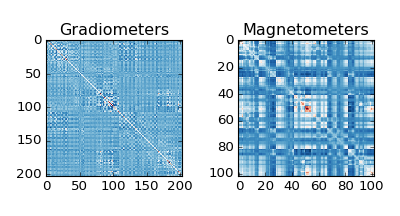

<IPython.core.display.Javascript object>


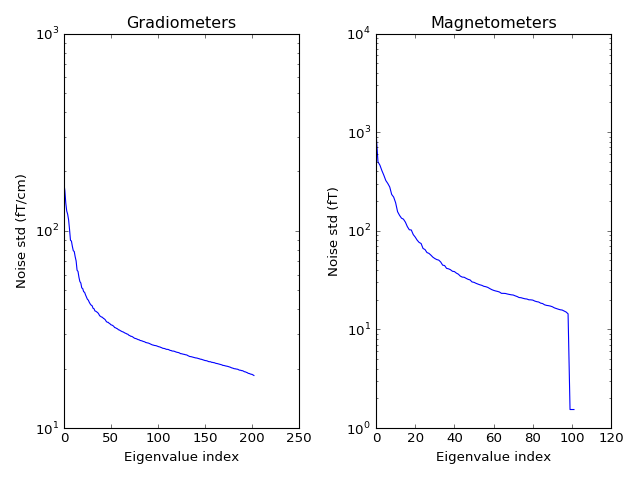

In [6]:
noise_cov = mne.compute_covariance(
    epochs, tmax=0., method=['shrunk', 'empirical'])

fig_cov, fig_spectra = mne.viz.plot_cov(noise_cov, raw.info)

<IPython.core.display.Javascript object>


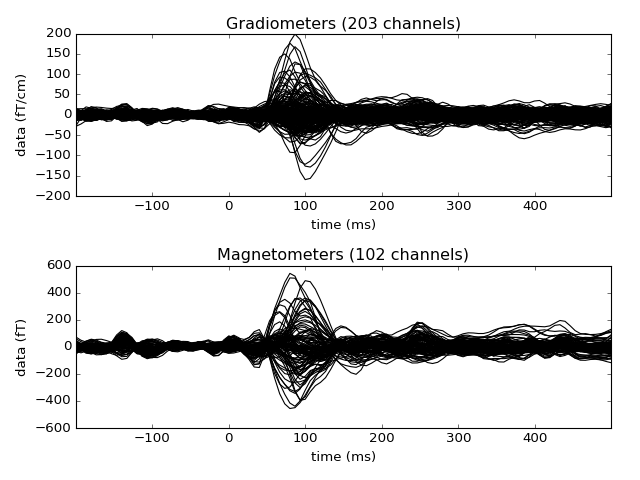

<IPython.core.display.Javascript object>


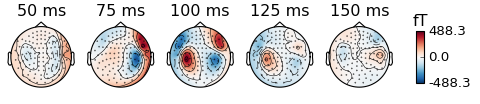

estimated rank (grad): 203
estimated rank (mag): 102
estimated rank (mag + grad): 305
Setting small MEG eigenvalues to zero.
Not doing PCA for MEG.


<IPython.core.display.Javascript object>


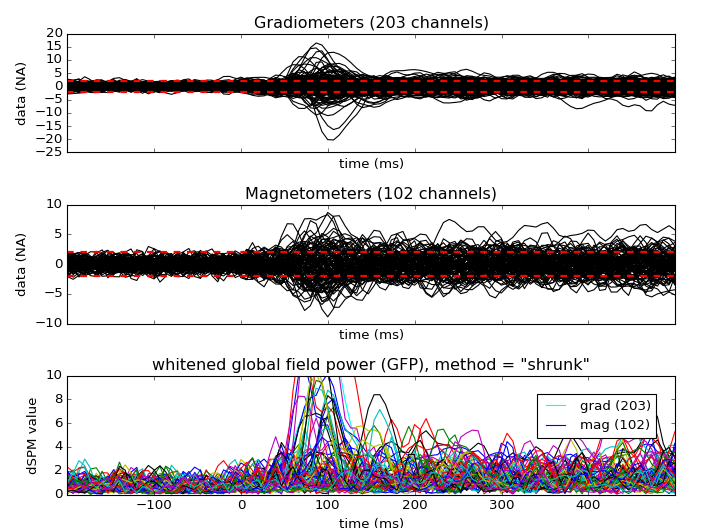

<IPython.core.display.Javascript object>


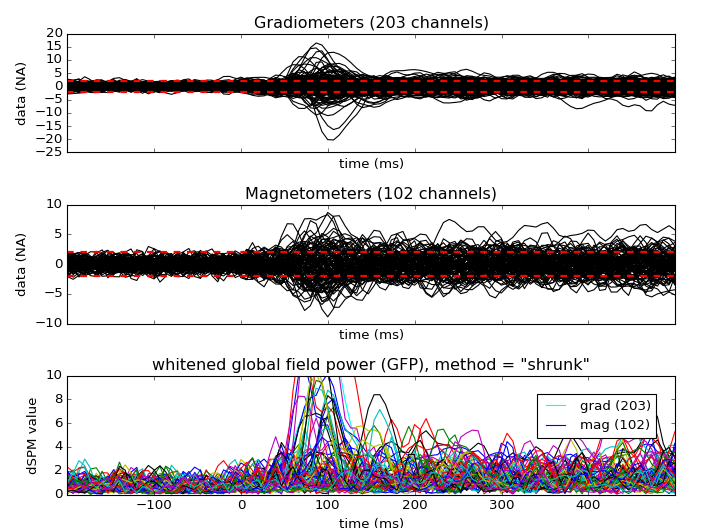

In [7]:
evoked = epochs.average()
evoked.plot()
evoked.plot_topomap(times=np.linspace(0.05, 0.15, 5), ch_type='mag')

# Show whitening
evoked.plot_white(noise_cov)

In [8]:
# Read the forward solution and compute the inverse operator

fname_fwd = data_path + '/MEG/sample/sample_audvis-meg-oct-6-fwd.fif'
fwd = mne.read_forward_solution(fname_fwd, surf_ori=True)

# Restrict forward solution as necessary for MEG
fwd = mne.pick_types_forward(fwd, meg=True, eeg=False)

# make an MEG inverse operator
info = evoked.info
inverse_operator = mne.minimum_norm.make_inverse_operator(info, fwd, noise_cov,
                                         loose=0.2, depth=0.8)

mne.minimum_norm.write_inverse_operator('sample_audvis-meg-oct-6-inv.fif',
                       inverse_operator)

Reading forward solution from /home/phil/mne_data/MNE-sample-data/MEG/sample/sample_audvis-meg-oct-6-fwd.fif...
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
    Desired named matrix (kind = 3523) not available
    Read MEG forward solution (7498 sources, 306 channels, free orientations)
    Source spaces transformed to the forward solution coordinate frame
    Converting to surface-based source orientations...
    Average patch normals will be employed in the rotation to the local surface coordinates....
[done]
    306 out of 306 channels remain after picking
Computing inverse operator with 305 channels.
    Created an SSP operator (subspace dimension = 3)
estimated rank (mag + grad): 302
Setting small MEG eigenvalues to zero.
Not

In [9]:
method = "dSPM"
snr = 3.
lambda2 = 1. / snr ** 2
stc = mne.minimum_norm.apply_inverse(evoked, inverse_operator, lambda2,
                    method=method, pick_ori=None)

del fwd, inverse_operator, epochs  # to save memory

Preparing the inverse operator for use...
    Scaled noise and source covariance from nave = 1 to nave = 55
    Created the regularized inverter
    Created an SSP operator (subspace dimension = 3)
    Created the whitener using a full noise covariance matrix (3 small eigenvalues omitted)
    Computing noise-normalization factors (dSPM)...
[done]
Picked 305 channels from the data
Computing inverse...
(eigenleads need to be weighted)...
combining the current components...
(dSPM)...
[done]


In [10]:
plt.plot(1e3 * stc.times, stc.data[::100, :].T)
plt.xlabel('time (ms)')
plt.ylabel('%s value' % method)
plt.show()

In [11]:
vertno_max, time_max = stc.get_peak(hemi='rh')

subjects_dir = data_path + '/subjects'
brain = stc.plot(surface='inflated', hemi='rh', subjects_dir=subjects_dir,
                 clim=dict(kind='value', lims=[8, 12, 15]),
                 initial_time=time_max, time_unit='s')
brain.add_foci(vertno_max, coords_as_verts=True, hemi='rh', color='blue',
               scale_factor=0.6)
brain.show_view('lateral')

********************************************************************************
         to build the TVTK classes (6.3). This may cause problems.
         Please rebuild TVTK.
********************************************************************************

Updating smoothing matrix, be patient..
Smoothing matrix creation, step 1
Smoothing matrix creation, step 2
Smoothing matrix creation, step 3
Smoothing matrix creation, step 4
Smoothing matrix creation, step 5
Smoothing matrix creation, step 6
Smoothing matrix creation, step 7
Smoothing matrix creation, step 8
Smoothing matrix creation, step 9
Smoothing matrix creation, step 10
colormap: fmin=8.00e+00 fmid=1.20e+01 fmax=1.50e+01 transparent=1


((-7.0167092985348768e-15, 90.0, 518.46453857421875, array([ 0.,  0.,  0.])),
 -90.0)